### Find inverse traces
This notebook shows now to predict inverse trace using first break piking model and Random Trees.

In [1]:
import sys
import torch
import segyio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B
from seismicpro.src import SeismicBatch, FieldIndex, TraceIndex, merge_picking_files, seismic_plot, KNNIndex

Firstly we load pretrained TCN model.

In [2]:
sys.path.append('/notebooks/kalashnikov/')
from TCN.mnist_pixel.model import TCN
input_channels = 1
n_classes = 2
nhid = 20
levels = 8
channel_sizes = [nhid] * levels
kernel_size = 3
dropout = 0
model = TCN(input_channels, n_classes, channel_sizes,
            kernel_size=kernel_size, dropout=dropout)
model.load_state_dict(torch.load('/notebooks/kalashnikov/TCN/mnist_pixel/model300',
                                 map_location='cpu'))

path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'

index = (FieldIndex(name='raw', path=path_raw, extra_headers=['offset']))

Now let's create a batch class instance. This batch class has a function to generate a dataset. The dataset consist the following params:
* the amplitude value at the point of the first break picking
* the difference between amplitude value on the N traces of neighors.
* offset
* the difference between time value of the first break picking on the N traces of neighbors.

In [79]:
from seismicpro.batchflow import action, inbatch_parallel
predict = lambda x: np.argmax(np.argmax(model(x).cpu().detach().numpy(), axis=1), axis=1)

class InvBatch(SeismicBatch):
    @action
    @inbatch_parallel(init='_init_component')
    def generate_inverse_dataset(self, index, model, num_neig, src, dst=None):
        """Generate dataset using given model and field data.
        
        Parameters
        ----------
        model : torch model
            model to predict first break picking.
        num_neig : int
            number of neighbours to compare model results.
        src : str
            component's name with data
        dst : str or None, optional
            component's name to save resulted data.
        """
        dst = src if dst is None else dst
        pos = self.get_pos(None, src, index)
        field = getattr(self, src)[pos]
        offset = np.array(self.index.get_df(index=index)['offset'])

        t = torch.Tensor(field).reshape(field.shape[0], 1, field.shape[1])
        inv_t = torch.Tensor(-field).reshape(field.shape[0], 1, field.shape[1])
        pred = np.array([predict(t), predict(inv_t)]).T

        traces_pred = pred.copy()
        data = []
        for i, (trace, inv_trace, norm_predict, off) in enumerate(zip(field, -field,
                                                                      pred, offset)):
            for j, (tr, pr) in enumerate([(trace, norm_predict[0]), (inv_trace,
                                                                     norm_predict[1])]):
                amp_val = tr[pr]
                amp_left = []
                amp_right = []
                inv_amp_left = []
                inv_amp_right = []
                diff_pred_left = []
                diff_pred_right = []
                inv_diff_pred_left = []
                inv_diff_pred_right = []
                for neig in range(1, num_neig+1):
                    if i >= neig and i <= len(norm_predict) - neig:
                        amp_left.append(amp_val - field[i-neig][pred[i-neig][0]])
                        amp_right.append(amp_val - field[i+neig][pred[i+neig][0]])
                        inv_amp_left.append(amp_val - (-1)*field[i-neig][pred[i-neig][1]])
                        inv_amp_right.append(amp_val - (-1)*field[i+neig][pred[i+neig][1]])
                        diff_pred_left.append(pred[i][j] - pred[i-neig][0])
                        diff_pred_right.append(pred[i][j] - pred[i+neig][0])
                        inv_diff_pred_left.append(pred[i][j] - pred[i-neig][1])
                        inv_diff_pred_right.append(pred[i][j] - pred[i+neig][1])
                    elif i < neig:
                        amp_left.append(0)
                        diff_pred_left.append(0)
                        inv_amp_left.append(0)
                        inv_diff_pred_left.append(0)
                        amp_right.append(amp_val - field[i+neig][pred[i+neig][0]])
                        inv_amp_right.append(amp_val - (-1)*field[i+neig][pred[i+neig][1]])
                        diff_pred_right.append(pred[i][j] - pred[i+neig][0])
                        inv_diff_pred_right.append(pred[i][j] - pred[i+neig][1])
                    else:
                        amp_right.append(0)
                        diff_pred_right.append(0)
                        inv_amp_right.append(0)
                        inv_diff_pred_right.append(0)
                        amp_left.append(amp_val - field[i-neig][pred[i-neig][0]])
                        diff_pred_left.append(pred[i][j] - pred[i-neig][0])
                        amp_left.append(amp_val - field[i-neig][pred[i-neig][0]])
                        inv_diff_pred_left.append(pred[i][j] - pred[i-neig][1])

                data.append([amp_val, off, *amp_left, *inv_amp_left, *amp_right, *inv_amp_right,
                             *diff_pred_left, *inv_diff_pred_left, *diff_pred_right, *inv_diff_pred_right,
                             j])
        getattr(self, dst)[pos] = data
        return self

Define pipeline and generate dataset.

In [69]:
def f(a):
    return (a - a.mean())/a.std()

ppl = (Dataset(index, InvBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=10, src='raw', dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

Split dataset on train and test.

In [71]:
z = ppl.next_batch(15)

diff = ppl.get_variable('diff')
data = np.concatenate(diff)

np.random.shuffle(data)
dataset, target = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(dataset, target)

Train Random Forest.

In [73]:
tree = RandomForestClassifier()
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now let's check the model quality. 

In [77]:
pred = tree.predict(X_test)
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.84      0.88      0.86      3211
        1.0       0.87      0.83      0.85      3073

avg / total       0.86      0.86      0.86      6284



And graw feature importance.

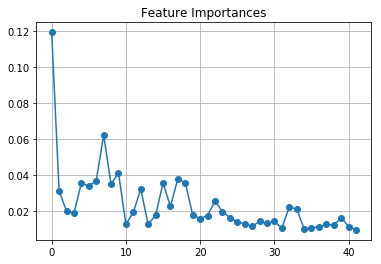

In [78]:
plt.title('Feature Importances')
plt.plot(range(len(tree.feature_importances_)), tree.feature_importances_, marker='o', )
plt.grid()